#Прогнозирование акций Лукойл



## Import dependencies

In [1]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

## Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/My Drive/акции лукойл/18_19.csv', sep=';')

In [5]:
#Выводим пять первых строк
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [6]:
#Выцепялем numpy значения .values
#И выводим нулевой
txt = base_data.values[0]
print(txt)

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [8]:
base_data16 = pd.read_csv('/content/drive/My Drive/акции лукойл/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/акции лукойл/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [9]:
data16_17.shape[0]

263925

In [12]:
# Выводим параметры одного файла
d = data18_19
print(len(d)) # Сколько есть записей
print(len(d.iloc[0])) # Длина одной строки данных
print(d.iloc[0]) # Пример первой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [13]:
# Объединяем базы из двух файлов
data = data16_17.copy()                 # Создаем копию первой базы
data = pd.concat([data16_17,data18_19]) # Присоединяем к ней вторую базу
data = np.array(data)                   # Превращаем в numpy массив

In [14]:
# Сравниваем размеры
print(len(data16_17)) # Выводим размер первой базы
print(len(data18_19)) # Выводим размер второй базы
print(len(data))      # Выводим размер суммарной базы

263925
217947
481872


## Data understanding

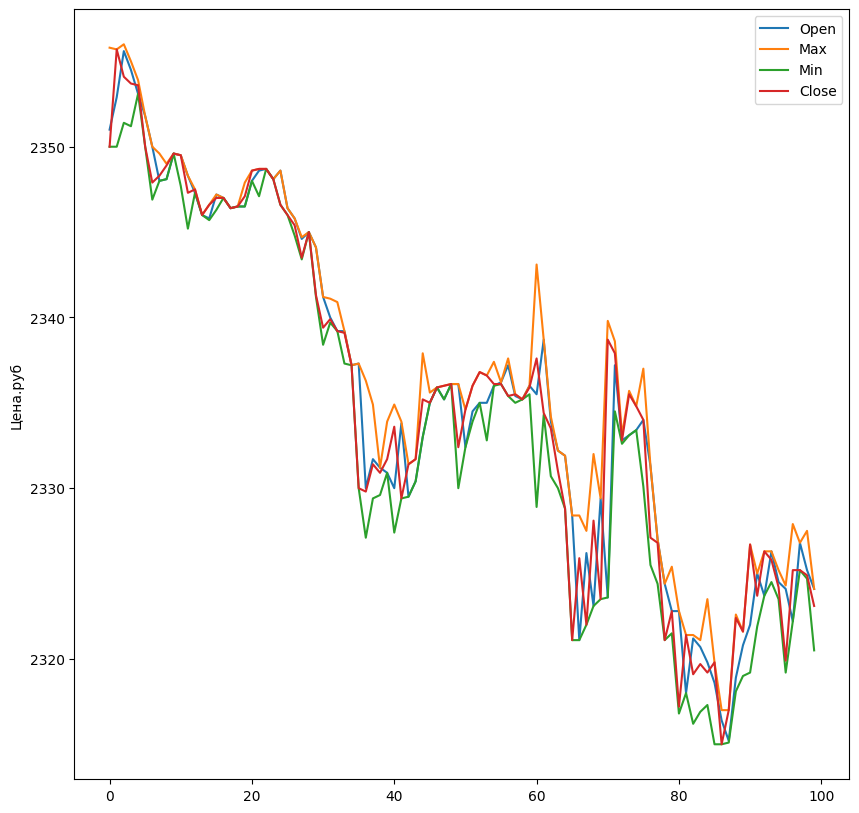

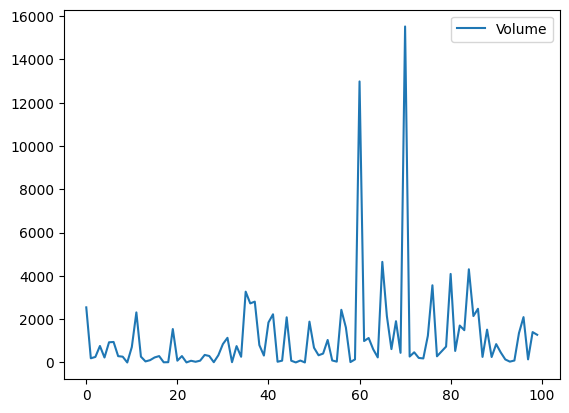

In [15]:
plt.figure(figsize=(10,10))
#Отображаем исходные от точки start и длинной stop
start = 0            #С какой точки начинаем
#stop = data.shape[0] #Сколько точек отрисуем
stop = 100 #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#Четыре основных канала - open, max, min, close
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+stop,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+stop,4], label="Volume")
plt.legend()
plt.show()

## Data Preparation

In [16]:
#Формируем параметры загрузки данных

x_len = 300                      #Анализируем по 300 прошедшим точкам 
val_len = 30000                  #Используем 30.000 записей для проверки

train_len = data.shape[0]-val_len # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
x_train,x_test = data[:train_len], data[train_len+x_len+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(x_train)
x_train = xScaler.transform(x_train)
x_test = xScaler.transform(x_test)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:train_len,3],(-1,1)), np.reshape(data[train_len+x_len+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(x_train, yTrain,           #В качестве параметров наши выборки
                               length=x_len, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины x_len)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(x_test, yTest,
                               length=x_len, stride=1,
                               batch_size=20)

In [17]:
yTrain[0]

array([0.07810564])

In [18]:
x_train[0]

array([0.07839171, 0.07822035, 0.07839814, 0.07810564, 0.00059283])

In [19]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 1)


## Полносвязная сеть

Epoch 1/2


<ipython-input-20-49ab406b7265>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelD.fit_generator(


22579/22579 [==============================] - 95s 4ms/step - loss: 0.0232 - val_loss: 8.5214e-05
Epoch 2/2
22579/22579 [==============================] - 89s 4ms/step - loss: 0.0084 - val_loss: 4.7980e-05


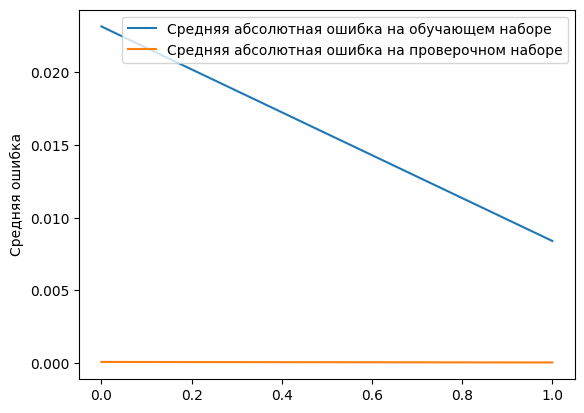

In [20]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (x_len,5), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=2, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()